Loading nesscessary libs

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, load_model, save_model
import matplotlib.pyplot as plt

**Setting Constrants**

In [5]:
  BATCH_SIZE =64
  IMAGE_SIZE=256
  CHANNELS=3#RGB
  EPOCHS = 12

**Loading** **data** **into** **tf**

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/Grad project/data/colored DS',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names=dataset.class_names
class_names

Found 35102 files belonging to 28 classes.


['بطاطس',
 'بطاطس مصابه ب لفحه مبكره',
 'بطاطس مصابه ب لفحه متأخره',
 'تفاح ',
 'تفاح مصاب بالجرب',
 'تفاح مصاب بالعفن الاسود',
 'خوخ',
 'خوخ مصاب ببقع بكتيرية',
 'ذرة',
 'ذرة  مصابه بالصدأ الشائع',
 'ذرة مصابه بتبقع أوراق رمادي',
 'ذرةمصابه لفحة ورقيه شماليه',
 'طماطم',
 'طماطم مصابه ب عث العنكبوت (الاكاروس)',
 'طماطم مصابه ببقع بكتيريه',
 'طماطم مصابه بتعفن في الأوراق',
 'طماطم مصابه بلفحه مبكره',
 'طماطم مصابه بلفحه متأخرة',
 'طماكم مصابه بفيروس تجعد واصفرار الأوراق',
 'عنب',
 'عنب مصاب بالحصبه السوداء (esca)',
 'عنب مصاب بالعفن الأسود',
 'فراولة',
 'فراولة مصابه باحتراق في الاوراق',
 'فلفل',
 'فلفل مصاب ببقع بكتيرية',
 'كرز',
 'كرز مصاب بالبياض الدقيقي']

**Visualize some of the images from our dataset**

In [7]:
!pip install python-bidi
!pip install arabic-reshaper

In [8]:
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
import arabic_reshaper

In [9]:
plt.figure(figsize=(20,20))

for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))

    # Arabic title processing
    arabic_text = class_names[label_batch[i]]
    reshaped_text = arabic_reshaper.reshape(arabic_text)
    artext = get_display(reshaped_text)

    # Set title with formatted Arabic text
    plt.title(artext)

    plt.axis("off")

plt.show()


Output hidden; open in https://colab.research.google.com to view.

**Split Dataset**

In [10]:
def split_dataset_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = split_dataset_tf(dataset)

**Cache, Shuffle, and Prefetch the Dataset**

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Creating a Layer for Resizing and Normalization**

In [13]:
resize_Rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

**Data Augmentation**

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

**Applying Data Augmentation to Train Dataset**

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Model Architecture**

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=28
model=models.Sequential([
    resize_Rescale,
    layers.Conv2D(32,(3,3), activation='relu',input_shape = input_shape),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),

])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (64, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (64, 62, 62, 64)          0         
 g2D)                                                 

**Compiling the Model**

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=12,
)

Epoch 1/12
384/384 [==============================] - 5165s 3s/step - loss: 1.8571 - accuracy: 0.4674 - val_loss: 2.4039 - val_accuracy: 0.4548
Epoch 2/12
384/384 [==============================] - 997s 3s/step - loss: 0.9158 - accuracy: 0.7156 - val_loss: 1.4900 - val_accuracy: 0.6138
Epoch 3/12
384/384 [==============================] - 1009s 3s/step - loss: 0.6513 - accuracy: 0.7917 - val_loss: 1.1550 - val_accuracy: 0.6839
Epoch 4/12
384/384 [==============================] - 983s 3s/step - loss: 0.4901 - accuracy: 0.8403 - val_loss: 1.1964 - val_accuracy: 0.7058
Epoch 5/12
384/384 [==============================] - 1005s 3s/step - loss: 0.4048 - accuracy: 0.8668 - val_loss: 0.8252 - val_accuracy: 0.7782
Epoch 6/12
384/384 [==============================] - 981s 3s/step - loss: 0.3338 - accuracy: 0.8892 - val_loss: 1.1150 - val_accuracy: 0.7098
Epoch 7/12
384/384 [==============================] - 1011s 3s/step - loss: 0.2962 - accuracy: 0.9000 - val_loss: 1.0723 - val_accuracy: 0.

**Saving the Model**

In [19]:
model.save("/content/drive/MyDrive/Colab Notebooks/Grad project/Gradproject.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**ُEvaluating the model**

In [17]:
# load the model
model = load_model("/content/drive/MyDrive/Colab Notebooks/Grad project/Gradproject.h5")

In [19]:
scores = model.evaluate(test_ds)

83/83 [==============================] - 54s 650ms/step - loss: 0.6630 - accuracy: 0.8328


In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

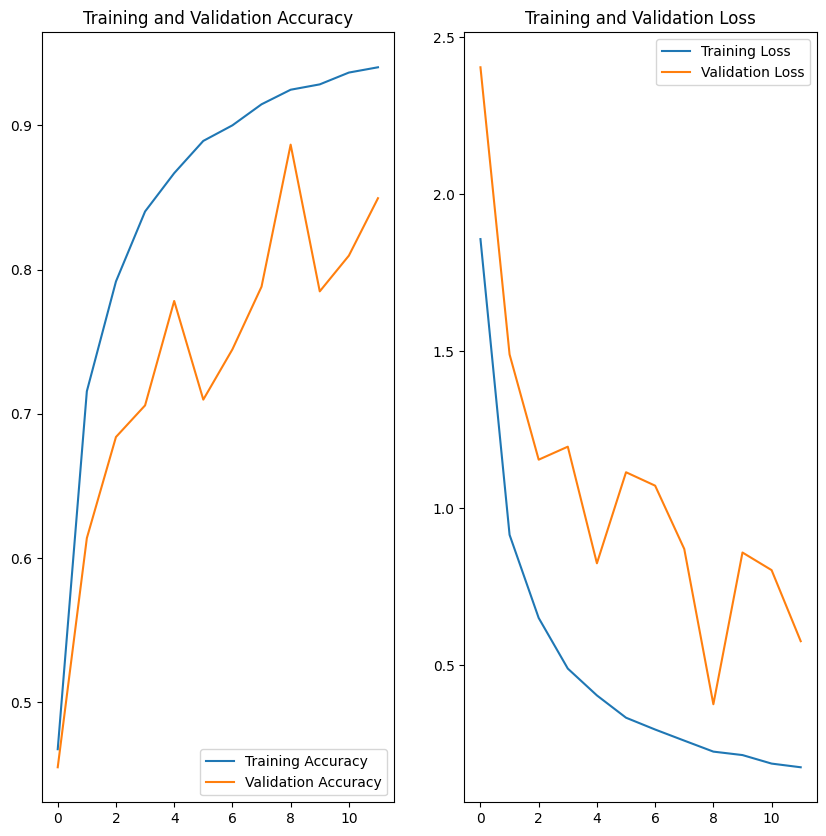

In [21]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Run prediction on a sample image**

first image to predict
actual label: فراولة مصابه باحتراق في الاوراق
2/2 [==============================] - 1s 342ms/step
predicted label: فراولة مصابه باحتراق في الاوراق


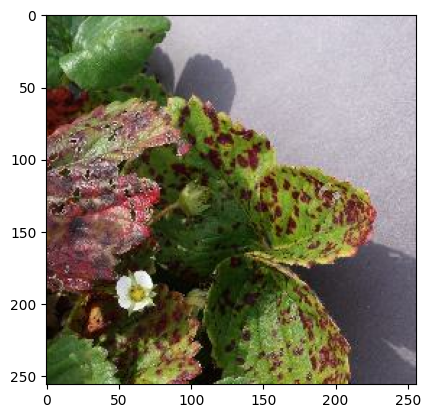

In [18]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [20]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


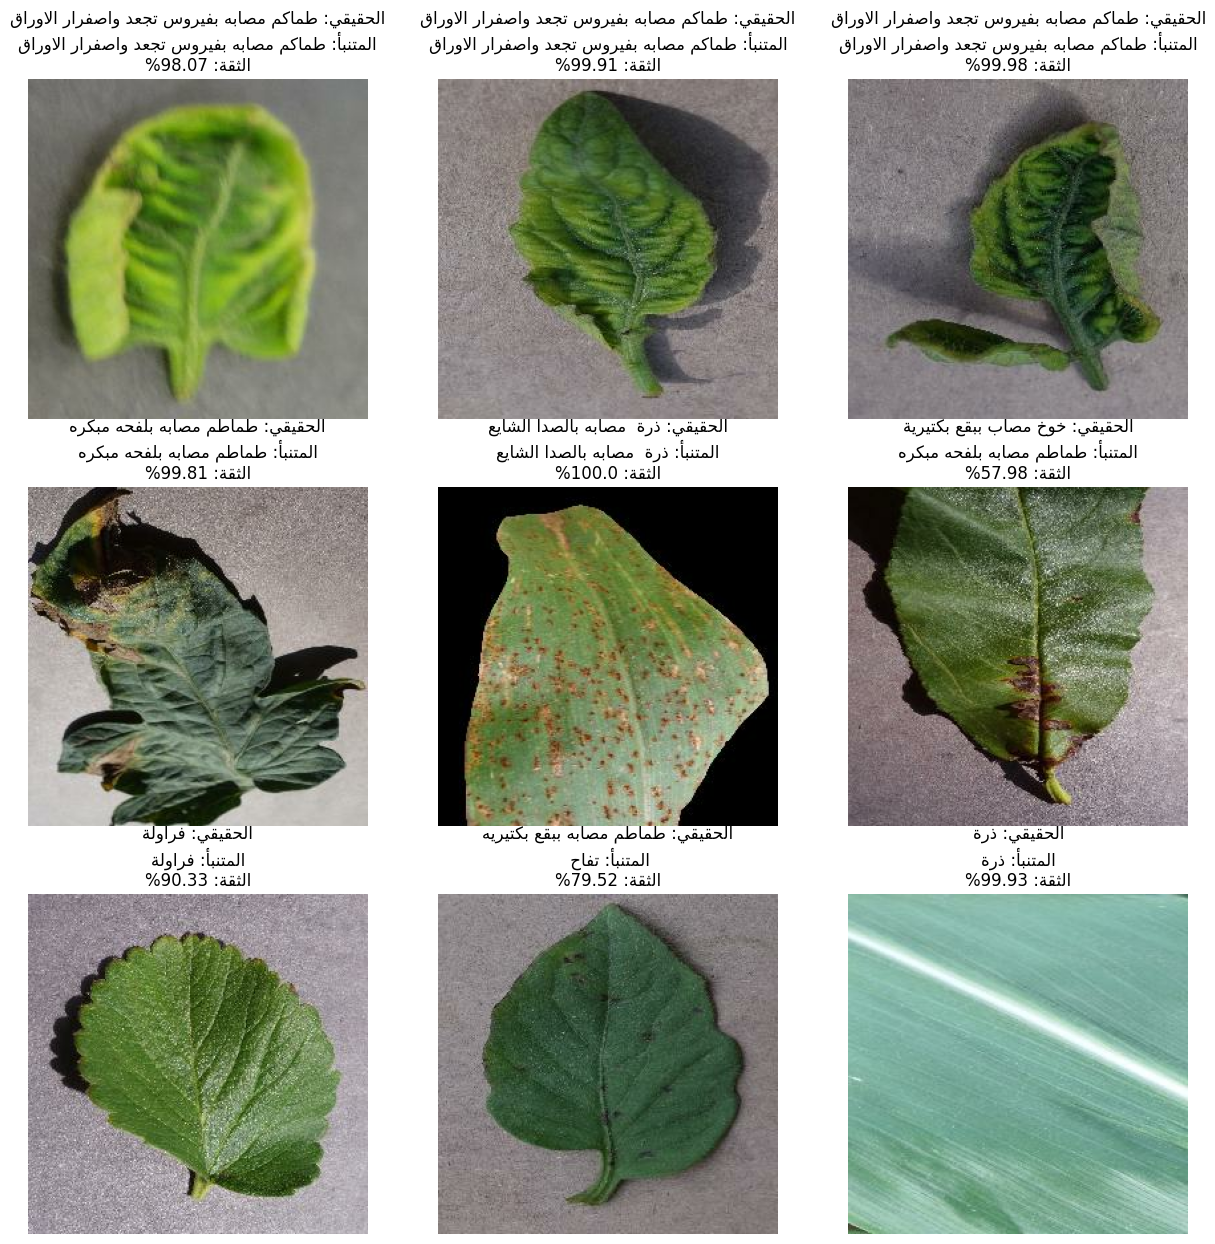

In [21]:
for images, labels in test_ds.take(1):
    plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        # Arabic title preparation
        actual_text = f"الحقيقي: {actual_class}"
        predicted_text = f"المتنبأ: {predicted_class}"
        confidence_text = f"الثقة: {confidence}%"

        # Reshape and format Arabic text
        actual_reshaped = arabic_reshaper.reshape(actual_text)
        predicted_reshaped = arabic_reshaper.reshape(predicted_text)
        confidence_reshaped = arabic_reshaper.reshape(confidence_text)

        actual_ar = get_display(actual_reshaped)
        predicted_ar = get_display(predicted_reshaped)
        confidence_ar = get_display(confidence_reshaped)

        # Combine title strings
        title = f"{actual_ar}\n{predicted_ar}\n{confidence_ar}"

        plt.title(title)
        plt.axis("off")

    plt.show()